In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance
from pandas import Series, DataFrame


In [ ]:
#Read dataset and mount dataset in google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Read dataset with port restriction
#df = pd.read_csv('/content/gdrive/MyDrive/Nasim/CICIDS_DATASETS/CICIDS2017_sample.csv') ### Haghighat 
df = pd.read_csv('/content/gdrive/MyDrive/Colab_project/CICIDS2017_sample.csv') ### Original ###
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [ ]:
df.Label.value_counts()

BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: Label, dtype: int64

Preprocessing (normalization and padding values)

In [ ]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

split train set and test set

In [ ]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [ ]:
X_train.shape

(45328, 77)

In [ ]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
6     1744
1     1573
4       29
dtype: int64

Oversampling by SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={4:2000}) # Create 2000 samples for the minority class "9"
#smote=SMOTE(n_jobs=-1,sampling_strategy={8:2000}) # Create 2000 samples for the minority class "8"
#X_train, y_train = smote.fit_resample(X_train, y_train)
#smote=SMOTE(n_jobs=-1,sampling_strategy={13:2000}) # Create 2000 samples for the minority class "13"
#X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

0    18184
3    15228
5     6357
2     2213
4     2000
6     1744
1     1573
dtype: int64

Analyze the model performance 

Machine learning model training

Training two base learners: Random Forest and KNN

Accuracy of RF: 0.995764581311215
Precision of RF: 0.9957586869590415
Recall of RF: 0.995764581311215
F1-score of RF: 0.9957435117511788
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4547
           1       0.98      0.97      0.98       393
           2       1.00      1.00      1.00       554
           3       1.00      1.00      1.00      3807
           4       1.00      0.71      0.83         7
           5       1.00      1.00      1.00      1589
           6       0.99      0.98      0.99       436

    accuracy                           1.00     11333
   macro avg       1.00      0.95      0.97     11333
weighted avg       1.00      1.00      1.00     11333



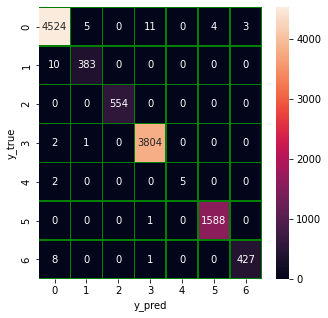

In [ ]:
# Random Forest training and prediction
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict_rf=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict_rf, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict_rf))
cm=confusion_matrix(y_true,y_predict_rf)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="green",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

**KNN**

Accuracy of KNN: 0.9847348451425042
Precision of KNN: 0.985100613012722
Recall of KNN: 0.9847348451425042
F1-score of KNN: 0.984834964401538
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4547
           1       0.90      0.95      0.93       393
           2       0.94      0.99      0.97       554
           3       0.99      1.00      0.99      3807
           4       0.44      0.57      0.50         7
           5       0.99      1.00      1.00      1589
           6       0.97      0.96      0.97       436

    accuracy                           0.98     11333
   macro avg       0.89      0.92      0.90     11333
weighted avg       0.99      0.98      0.98     11333



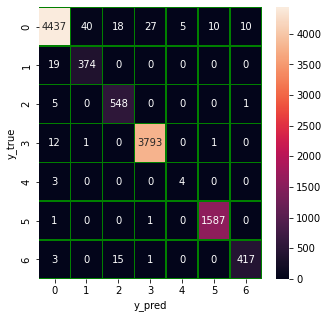

In [ ]:
#  k-Nearest Neighbors (kNN) training and prediction
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train, y_train)
y_predict_knn = classifier.predict(X_test) 
kn=classifier.score(X_test,y_test)
y_true=y_test
print('Accuracy of KNN: '+ str(kn))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict_knn, average='weighted') 
print('Precision of KNN: '+(str(precision)))
print('Recall of KNN: '+(str(recall)))
print('F1-score of KNN: '+(str(fscore)))
print(classification_report(y_true,y_predict_knn))
cm=confusion_matrix(y_true,y_predict_knn)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="green",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
classifier_train=classifier.predict(X_train)
classifier_test=classifier.predict(X_test)

Aggregation of Classifiers based on K-Means Clustering

Aggregation of Classifiers based on ISO 27005 & 31000

In [ ]:
res = y_predict_rf == y_predict_knn

In [ ]:
y_predict_knn[~res]

array([3, 1, 1, 3, 0, 0, 3, 6, 1, 1, 2, 2, 0, 4, 3, 1, 4, 1, 1, 1, 0, 1,
       1, 2, 3, 0, 0, 2, 5, 3, 0, 4, 0, 3, 0, 2, 2, 2, 1, 3, 3, 0, 6, 5,
       2, 1, 6, 6, 1, 6, 1, 3, 1, 1, 1, 1, 0, 1, 4, 6, 2, 6, 1, 0, 0, 1,
       2, 5, 2, 2, 2, 2, 1, 2, 5, 3, 0, 1, 2, 3, 0, 3, 1, 5, 5, 2, 1, 6,
       3, 1, 1, 2, 1, 1, 3, 0, 0, 0, 1, 0, 2, 6, 0, 2, 0, 2, 4, 6, 6, 3,
       6, 6, 0, 3, 0, 6, 1, 0, 3, 0, 2, 0, 1, 6, 2, 0, 2, 0, 3, 0, 1, 4,
       6, 3, 0, 2, 2, 0, 6, 5, 0, 2, 2, 1, 2, 2, 1, 0, 1, 1, 1, 2, 0, 1,
       3, 2, 0, 1, 0, 2, 0])

In [ ]:
y_predict_rf[~res]

array([0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 6, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 5, 6, 6, 0, 0, 3, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 6, 0,
       0, 0, 6, 6, 6, 6, 0, 6, 3, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 0, 3, 6, 0, 1, 6, 3, 0, 0, 0, 0, 0,
       0, 0, 4, 0, 1, 0, 0, 1, 0, 3, 6, 3, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0,
       0, 0, 4, 0, 0, 6, 0, 0, 3, 0, 6, 0, 6, 0, 0, 3, 0, 0, 0, 6, 2, 0,
       0, 0, 3, 0, 1, 0, 3])

In [ ]:
y = []
for i in range(len(y_predict_rf)):
  t = (y_predict_knn[i], y_predict_rf[i])
  i = np.nonzero(t)
  y.append(t[i[0][0]] if len(i[0]) > 0 else 0)
y = np.array(y)

In [ ]:
y_predict_rf[y_predict_rf != y]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 0, 6, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       6, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0])

In [ ]:
y_predict_knn[y_predict_knn != y]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y[y_predict_rf != y]

array([3, 1, 1, 3, 3, 6, 1, 1, 2, 2, 4, 3, 1, 4, 1, 1, 1, 1, 1, 2, 3, 2,
       5, 3, 4, 3, 2, 2, 2, 1, 3, 3, 6, 5, 2, 1, 6, 6, 1, 6, 1, 3, 1, 1,
       1, 1, 1, 4, 6, 2, 6, 1, 1, 2, 5, 2, 2, 2, 2, 1, 2, 5, 3, 1, 2, 3,
       3, 1, 5, 5, 2, 1, 6, 3, 1, 1, 2, 1, 1, 3, 1, 2, 6, 2, 2, 4, 6, 6,
       3, 6, 6, 3, 6, 1, 3, 2, 1, 6, 2, 2, 3, 1, 4, 6, 3, 2, 2, 6, 5, 2,
       2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 3, 2, 1, 2])

In [ ]:
y[y_predict_knn != y]

array([3, 1, 2, 1, 5, 6, 3, 1, 3, 1, 1, 1, 6, 1, 1, 3, 3, 2, 3, 1, 3, 4,
       1, 1, 3, 3, 1, 1, 2, 4, 6, 3, 3, 2, 3, 1, 3])

Accuracy of proposed method: 0.9967351980940616
Precision of proposed method: 0.9873823090846398
Recall of proposed method: 0.986764316597547
F1-score of proposed method: 0.9868941902226274


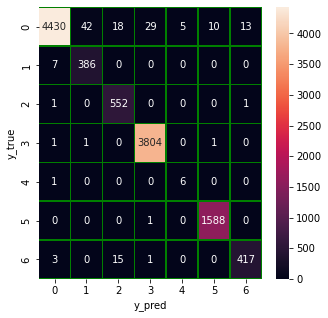

In [ ]:
# I added these two lines
ac=classifier.score(X_test,y)
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y, average='weighted')

# I corrected the print instractions
print('Accuracy of proposed method: '+ (str(ac)))
print('Precision of proposed method: '+ (str(precision)))
print('Recall of proposed method: '+ (str(recall)))
print('F1-score of proposed method: '+ (str(fscore)))

# Same as before without any modifications
cm=confusion_matrix(y_true,y)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="green",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
#TYPE OF ATTACK
#BENIGN                        2273097
#DoS Hulk                       231073
#PortScan                       158930
#DDoS                           128027
#DoS GoldenEye                   10293
#FTP-Patator                      7938
#SSH-Patator                      5897
#DoS slowloris                    5796
#DoS Slowhttptest                 5499
#Bot                              1966
#Web Attack � Brute Force         1507
#Web Attack � XSS                  652
#Infiltration                       36
#Web Attack � Sql Injection         21
#Heartbleed                         11

